In [79]:
import os
import sys

import json
from scripts.fedAvg import FedAvg
import matplotlib.pyplot as plt

import re
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc

In [72]:
RESULT_PATH = './results/'
MODELS_PATH = './models/'

## Description
The title of each plot represent:
<ul>
<li> Num_round
<li> Epochs
<li> Number of devices
</ul>

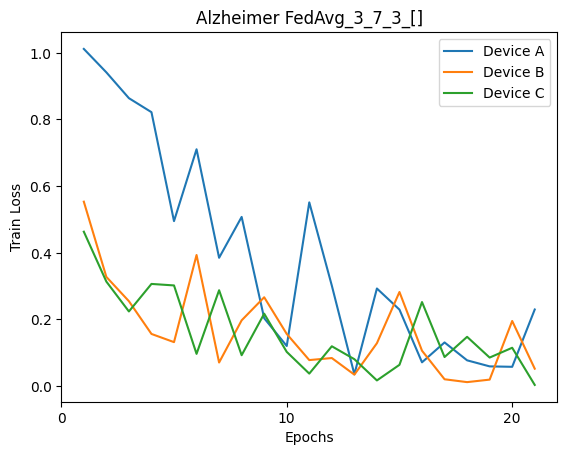

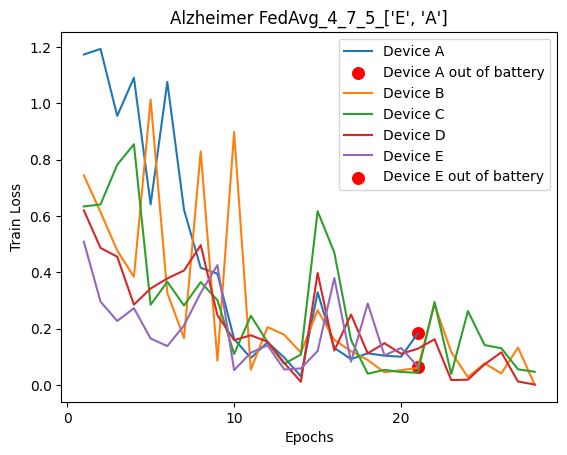

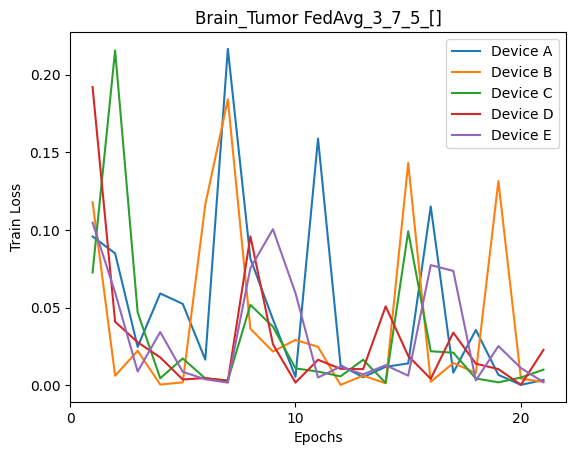

In [73]:
def create_dictionary(json_data):
    output = {}
    out_of_battery = []
    for key in json_data.keys():
        epoch_loss = []
        for round,dict_loss in json_data[key].items():
            if dict_loss == "out_of_battery":
                out_of_battery.append(key)
                losses = []
            else:
                losses = [float(ep[0]) for ep in dict_loss.values()]
            #print(losses)
            epoch_loss += losses
        output[key] = epoch_loss

    return output, set(out_of_battery)


for dir in os.listdir(RESULT_PATH):
  for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
    if data_file.endswith('.json'):
        path = os.path.join(RESULT_PATH,dir,data_file)
        with open(path, 'r') as file:
          data = json.load(file)

        pattern = re.compile(r'')
        title = re.sub(pattern, lambda match: match.group(0).replace('_', ''), data_file)
        output, out_of_battery = create_dictionary(data)
        # Flatten the JSON data

        max_length = max(len(values) for values in output.values())

        # Define your list of integer values for the x-axis
        x_values = (range(1, max_length + 1))
        for key, values in output.items():
            x_values = (range(1, len(values) + 1))
            plt.plot(x_values, values, label=f"Device {key}")
            if key in out_of_battery:
                plt.scatter(x_values[-1], values[-1], label=f"Device {key} out of battery", marker='o', color='red',s=70)


        # Adding labels and legend
        plt.title(dir + ' ' + data_file.removesuffix('.json'))
        plt.xlabel('Epochs')
        plt.ylabel('Train Loss')
        plt.legend()

        plt.xticks([0] + [x for x in x_values[1:] if x % 10 == 0])
        # Show the plot
        plt.show()

In [75]:
# Take the test set
test_path = 'off_chain/test'
test_set = tf.data.Dataset.load(test_path)

In [96]:
for dataset in os.listdir(MODELS_PATH):
    if dataset == "Alzheimer":
        labels = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
    else:
        labels = ["glioma", "meningioma", "notumor", "pituitary"]
    for configuration in sorted(os.listdir(os.path.join(MODELS_PATH,dataset))):
        model = FedAvg()
        model.load_weights(MODELS_PATH + dataset + '/' + configuration + '/')
        results = model.predict(test_set.map(lambda x, y: x))
        y_predicted = list((map(np.argmax, results)))
        labels_y_test = list(test_set.unbatch().map(lambda x, y: (tf.argmax(y))))
        print()
        print(f"\t\tClassification Report for {dataset} {configuration}")
        print(
        classification_report(
            labels_y_test,
            y_predicted,
            target_names=labels,
            zero_division=False
            )
        )

        # ROC CURVE
        """
        y_probabilities = predict_probabilities(model, test_set.map(lambda x, y: x))

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(test_set.map(lambda x,y : y), y_probabilities)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        """


41/41 [==============================] - 4s 90ms/step

		Classification Report for Brain_Tumor FedAvg_2_1_[]
              precision    recall  f1-score   support

      glioma       0.88      0.57      0.69       299
  meningioma       0.57      0.58      0.58       301
     notumor       0.85      0.92      0.89       381
   pituitary       0.79      0.96      0.87       300

    accuracy                           0.77      1281
   macro avg       0.77      0.76      0.75      1281
weighted avg       0.78      0.77      0.76      1281



In [43]:
from prettytable import PrettyTable
import numpy as np
for dir in sorted(os.listdir(RESULT_PATH)):
    table = PrettyTable()
    table.field_names = ["N. Devices","Agg. Method", "Round", "Epochs","Dev. OFB","Accuracy"]
    
    for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
        if data_file.endswith('accuracy.json'):
           
           path = os.path.join(RESULT_PATH,dir,data_file)
           
           with open(path, 'r') as file:
              data = json.load(file)
           max_val = np.round(np.max(list(data.values())),2)
           
           pattern = re.compile(r'\[.*?\]')
           info = re.sub(pattern, lambda match: match.group(0).replace('_', ''), data_file)
           info = info.split('_')
           if len(info) == 8:
              info = [' '.join(info[:2])] + info[2:]

           row = [info[4],info[1],info[2],info[3],info[5],max_val]
           

           table.add_row(row)
    table.title = dir
    table.sortby = "Accuracy"
    table.reversesort = True
    print(table)

ModuleNotFoundError: No module named 'prettytable'